<a href="https://colab.research.google.com/github/Abhishek500/ERA/blob/main/S7/ERA_S7_C3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from google.colab import drive
drive.mount('/content/drive')
import sys
sys.path.insert(0,'/content/drive/My Drive/ERA V1')
from model import *

In [2]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


In [3]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

100%|██████████| 9912422/9912422 [00:00<00:00, 244815022.78it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 122980399.82it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 231339401.12it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 2712977.61it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(-0.0001)
 - std: tensor(1.0000)
 - var: tensor(1.0001)
torch.Size([128, 1, 28, 28])
torch.Size([128])


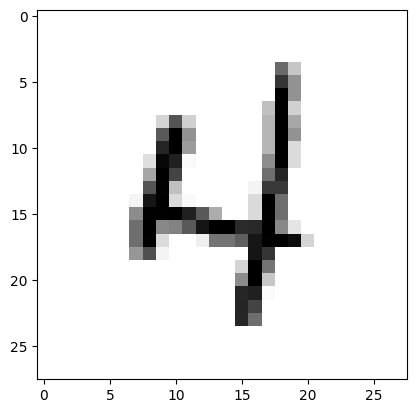

In [ ]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')


In [10]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Model3().to(device)
summary(model, input_size=(1, 28, 28))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]             100
            Conv2d-2           [-1, 10, 24, 24]             910
         MaxPool2d-3           [-1, 10, 12, 12]               0
            Conv2d-4           [-1, 10, 10, 10]             910
            Conv2d-5             [-1, 16, 8, 8]           1,456
            Conv2d-6              [-1, 8, 6, 6]           1,160
            Conv2d-7             [-1, 10, 1, 1]           2,890
Total params: 7,426
Trainable params: 7,426
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.12
Params size (MB): 0.03
Estimated Total Size (MB): 0.16
----------------------------------------------------------------


In [11]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

In [12]:
model =  Model3().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

EPOCH: 0


Loss=0.16678088903427124 Batch_id=468 Accuracy=79.04: 100%|██████████| 469/469 [00:27<00:00, 16.96it/s]



Test set: Average loss: 0.1439, Accuracy: 9580/10000 (95.80%)

EPOCH: 1


Loss=0.18612128496170044 Batch_id=468 Accuracy=96.47: 100%|██████████| 469/469 [00:23<00:00, 20.29it/s]



Test set: Average loss: 0.0803, Accuracy: 9746/10000 (97.46%)

EPOCH: 2


Loss=0.08107871562242508 Batch_id=468 Accuracy=97.41: 100%|██████████| 469/469 [00:16<00:00, 28.03it/s]



Test set: Average loss: 0.0681, Accuracy: 9787/10000 (97.87%)

EPOCH: 3


Loss=0.040432896465063095 Batch_id=468 Accuracy=97.87: 100%|██████████| 469/469 [00:17<00:00, 26.40it/s]



Test set: Average loss: 0.0543, Accuracy: 9830/10000 (98.30%)

EPOCH: 4


Loss=0.08514568209648132 Batch_id=468 Accuracy=98.26: 100%|██████████| 469/469 [00:16<00:00, 28.17it/s]



Test set: Average loss: 0.0487, Accuracy: 9845/10000 (98.45%)

EPOCH: 5


Loss=0.03214973211288452 Batch_id=468 Accuracy=98.35: 100%|██████████| 469/469 [00:17<00:00, 26.42it/s]



Test set: Average loss: 0.0456, Accuracy: 9858/10000 (98.58%)

EPOCH: 6


Loss=0.04262124374508858 Batch_id=468 Accuracy=98.55: 100%|██████████| 469/469 [00:17<00:00, 27.48it/s]



Test set: Average loss: 0.0423, Accuracy: 9873/10000 (98.73%)

EPOCH: 7


Loss=0.031393323093652725 Batch_id=468 Accuracy=98.67: 100%|██████████| 469/469 [00:19<00:00, 24.30it/s]



Test set: Average loss: 0.0371, Accuracy: 9878/10000 (98.78%)

EPOCH: 8


Loss=0.013214302249252796 Batch_id=468 Accuracy=98.75: 100%|██████████| 469/469 [00:17<00:00, 27.53it/s]



Test set: Average loss: 0.0412, Accuracy: 9878/10000 (98.78%)

EPOCH: 9


Loss=0.023987622931599617 Batch_id=468 Accuracy=98.81: 100%|██████████| 469/469 [00:17<00:00, 26.56it/s]



Test set: Average loss: 0.0390, Accuracy: 9875/10000 (98.75%)

EPOCH: 10


Loss=0.03795628622174263 Batch_id=468 Accuracy=98.84: 100%|██████████| 469/469 [00:17<00:00, 26.51it/s]



Test set: Average loss: 0.0419, Accuracy: 9876/10000 (98.76%)

EPOCH: 11


Loss=0.014467775821685791 Batch_id=468 Accuracy=98.95: 100%|██████████| 469/469 [00:17<00:00, 26.37it/s]



Test set: Average loss: 0.0374, Accuracy: 9886/10000 (98.86%)

EPOCH: 12


Loss=0.007882564328610897 Batch_id=468 Accuracy=99.03: 100%|██████████| 469/469 [00:16<00:00, 28.14it/s]



Test set: Average loss: 0.0361, Accuracy: 9892/10000 (98.92%)

EPOCH: 13


Loss=0.06971899420022964 Batch_id=468 Accuracy=99.12: 100%|██████████| 469/469 [00:17<00:00, 27.03it/s]



Test set: Average loss: 0.0379, Accuracy: 9882/10000 (98.82%)

EPOCH: 14


Loss=0.06081812456250191 Batch_id=468 Accuracy=99.08: 100%|██████████| 469/469 [00:17<00:00, 26.76it/s]



Test set: Average loss: 0.0334, Accuracy: 9890/10000 (98.90%)



Text(0.5, 1.0, 'Test Accuracy')

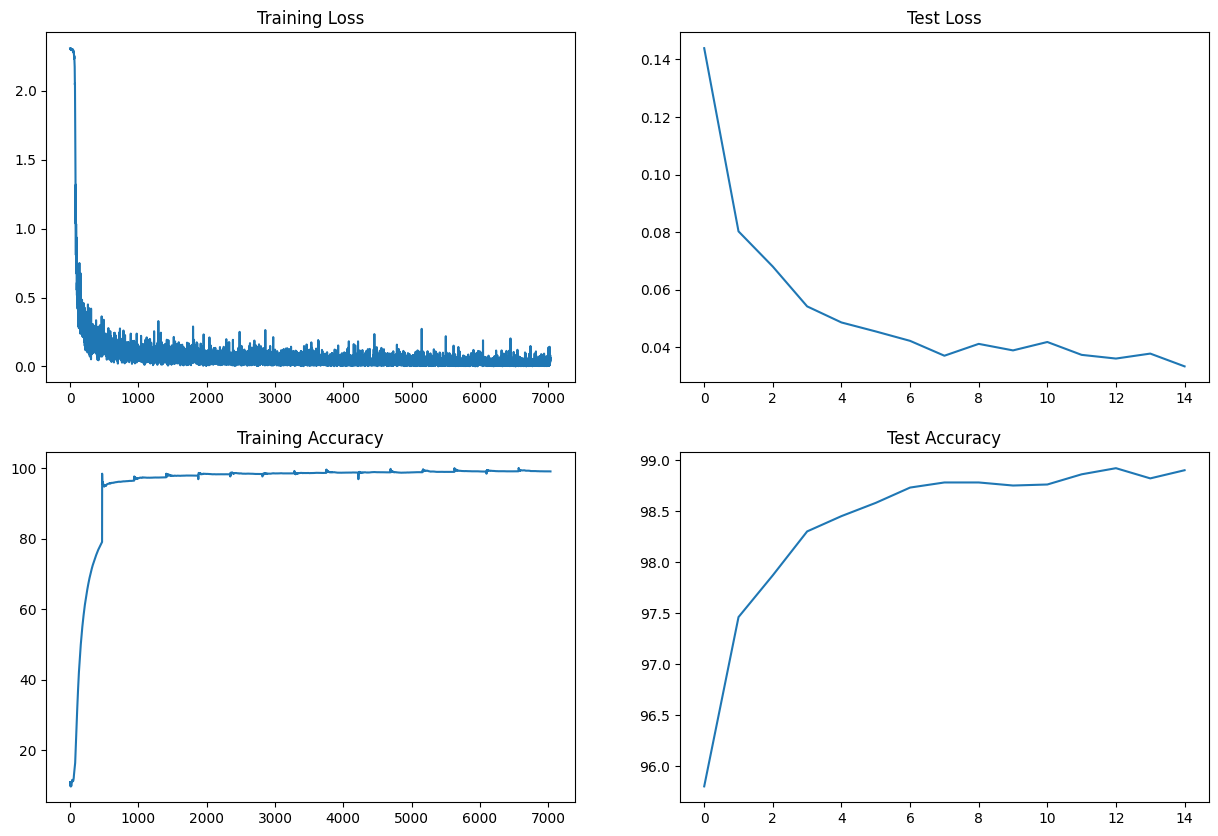

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
t = [t_items.item() for t_items in train_losses]
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(t)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

**Target:**


1.   Make the model lighter



**Result:**

1.   Parameters: 7,426
2.   Best Train Accuracy: 99.12
3.   Best Test Accuracy: 98.92


**Analysis:**


1.   The model is not learning post 7th epoch. Even the training accuracy is poor. There is mild overfitting. We need to introduce image augmentation and introduce GAP. By GAP, we reduce the parameters needed in last layer, which we can then use to increase in previous layers.
2.   To improve the training accuracy, we can try different optimizer, learning rate and reduce the batch size to avoid the model from getting stuck in local minima

